# Skin Cancer

## 1.1 downloading the dataset

In [62]:
import kagglehub
import shutil

path = kagglehub.dataset_download("rm1000/skin-cancer-isic-images")
shutil.copytree(path, './data/skin-cancer')

'./data/skin-cancer'

## read and resize

In [293]:
import tensorflow as tf

# tf.keras.utils.image
val_ds = tf.keras.utils.image_dataset_from_directory(
  "./data/skin-cancer",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(100, 100),
  batch_size=32)

train_ds = tf.keras.utils.image_dataset_from_directory(
  "./data/skin-cancer",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(100, 100),
  batch_size=32)

Found 3297 files belonging to 2 classes.
Using 659 files for validation.
Found 3297 files belonging to 2 classes.
Using 2638 files for training.


## normalization

In [294]:
import matplotlib.pyplot as plt

def preprocess_image(image, label):
    # image = tf.image.rgb_to_grayscale(image)
    image = image / 255.0
    return image, label

train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)

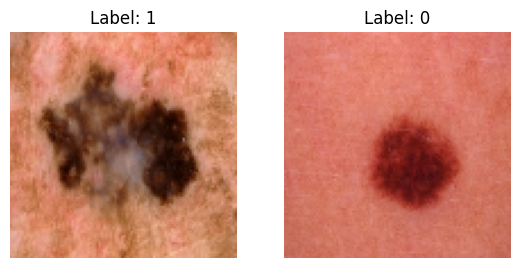

In [295]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(2):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i].numpy()}')
        plt.axis('off')
    plt.show()

## no augmentation yet

## model

In [298]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3), use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', use_bias=True))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=32, activation='relu', use_bias=True))
model.add(Dense(units=8, activation='relu', use_bias=True))
model.add(Dense(units=1, activation='sigmoid', use_bias=True)) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_108 (Conv2D)             │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_107               │ (None, 49, 49, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 47, 47, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 23, 23, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 10, 10, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_110               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,281 (637.82 KB)

 Trainable params: 163,281 (637.82 KB)

 Non-trainable params: 0 (0.00 B)

In [299]:
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=32)
history = model.fit(train_ds, validation_data=val_ds, epochs=10, batch_size=32)

test_loss, test_acc = model.evaluate(val_ds)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.5336 - loss: 0.6765 - val_accuracy: 0.7936 - val_loss: 0.4884
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7304 - loss: 0.5184 - val_accuracy: 0.7860 - val_loss: 0.4645
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7849 - loss: 0.4565 - val_accuracy: 0.8058 - val_loss: 0.4035
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7907 - loss: 0.4398 - val_accuracy: 0.7967 - val_loss: 0.3998
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7924 - loss: 0.4419 - val_accuracy: 0.8073 - val_loss: 0.3811
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7851 - loss: 0.4208 - val_accuracy: 0.7967 - val_loss: 0.3802
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8013 - loss: 0.4046 - val_accuracy: 0.8149 - val_loss: 0.3828
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8066 - loss: 0.3967 - val_accuracy: 0.8088 - v

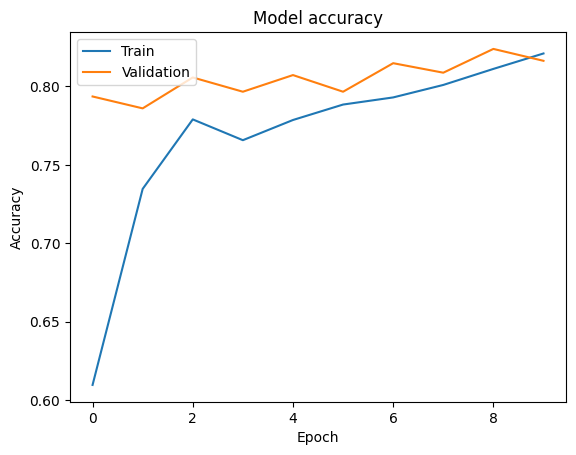

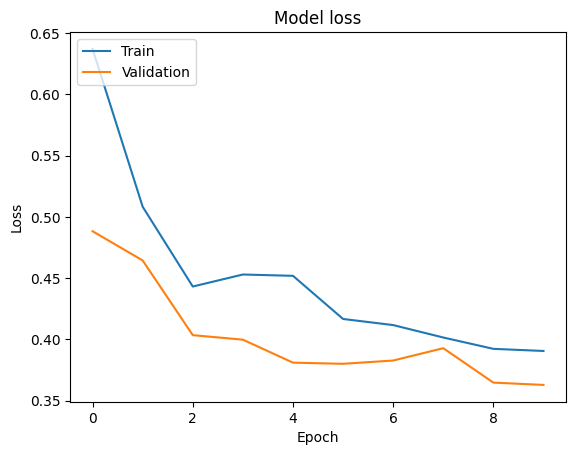

In [300]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()